In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
from scipy.signal import savgol_filter as sf

In [5]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [6]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.341,0.121,0.245,0.009,0.085,0.154,0.161,0.311,0.358,0.177,...,0.372,0.181,0.322,0.374,0.571,0.453,0.161,0.127,0.259,0.364
2018-05-01 01:00:00,0.337,0.186,0.285,0.010,0.071,0.127,0.179,0.225,0.206,0.178,...,0.245,0.238,0.292,0.382,0.327,0.352,0.172,0.133,0.234,0.286
2018-05-01 02:00:00,0.324,0.214,0.487,0.009,0.061,0.139,0.182,0.221,0.150,0.152,...,0.245,0.250,0.287,0.320,0.359,0.366,0.242,0.219,0.197,0.368
2018-05-01 03:00:00,0.319,0.250,0.300,0.009,0.067,0.132,0.172,0.274,0.142,0.205,...,0.177,0.223,0.329,0.170,0.322,0.267,0.269,0.164,0.229,0.414
2018-05-01 04:00:00,0.235,0.199,0.107,0.009,0.047,0.131,0.153,0.255,0.139,0.169,...,0.129,0.171,0.301,0.168,0.351,0.255,0.170,0.132,0.198,0.318


In [7]:
# 1월치 데이터 파싱
m_15_1 = m_15[m_15.index.month == 1].copy()
m_15_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.008,0.0,0.013,0.009,0.015,0.100,0.059,0.026,0.090,0.066,...,0.068,0.024,0.090,0.097,0.131,0.103,0.115,0.062,0.090,0.172
2019-01-01 00:15:00,0.008,0.0,0.007,0.009,0.016,0.083,0.061,0.059,0.106,0.021,...,0.141,0.049,0.112,0.103,0.094,0.187,0.125,0.076,0.048,0.165
2019-01-01 00:30:00,0.008,0.0,0.007,0.010,0.016,0.077,0.057,0.078,0.098,0.082,...,0.174,0.068,0.094,0.062,0.124,0.165,0.146,0.061,0.085,0.185
2019-01-01 00:45:00,0.009,0.0,0.007,0.009,0.015,0.062,0.063,0.132,0.079,0.074,...,0.151,0.047,0.104,0.056,0.071,0.171,0.098,0.090,0.082,0.130
2019-01-01 01:00:00,0.008,0.0,0.012,0.009,0.016,0.037,0.071,0.111,0.084,0.045,...,0.112,0.065,0.080,0.065,0.104,0.124,0.127,0.089,0.064,0.153


In [8]:
m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


In [9]:
m_60_1[m_60_1.columns[:5]].head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063


In [23]:
len(m_60_1)

744

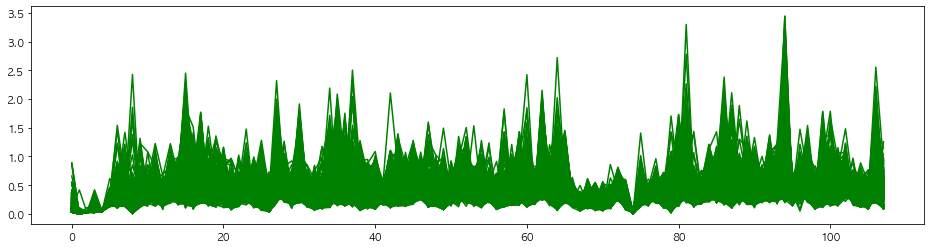

In [61]:
y = m_60_1.values.T
x = np.arange(len(m_60_1.T))
sf(y, 345, 3)

plt.figure(figsize=(16,4))

plt.plot(x, y, color='g')

plt.show()

In [48]:
x = np.arange(len(m_60_1))
y = m_60_1['아파트1-104-1206'].values
yhat = sf(y, 69, 3)

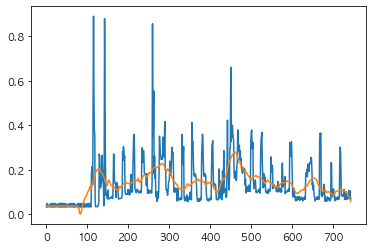

In [49]:
plt.plot(x, y)
plt.plot(x, yhat)

array([0.02613359, 0.02687626, 0.02761715, 0.02835625, 0.02909357,
       0.0298291 , 0.03056284, 0.0312948 , 0.03202498, 0.03275336,
       0.03347996, 0.03420478, 0.03492781, 0.03564905, 0.03636851,
       0.03708618, 0.03780207, 0.03851617, 0.03922849, 0.03993901,
       0.04064776, 0.04135471, 0.04205988, 0.04276327, 0.04346487,
       0.04416468, 0.04486271, 0.04555895, 0.04625341, 0.04694608,
       0.04763696, 0.04832606, 0.04901337, 0.0496989 , 0.05038264,
       0.0510646 , 0.05174477, 0.05242315, 0.05309975, 0.05377456,
       0.05444758, 0.05511882, 0.05578828, 0.05645595, 0.05712183,
       0.05778593, 0.05844824, 0.05910876, 0.0597675 , 0.06042445,
       0.06107962, 0.061733  , 0.0623846 , 0.06303441, 0.06368243,
       0.06432867, 0.06497312, 0.06561579, 0.06625667, 0.06689576,
       0.06753307, 0.06816859, 0.06880233, 0.06943428, 0.07006445,
       0.07069283, 0.07131942, 0.07194423, 0.07256725, 0.07318849,
       0.07380794, 0.0744256 , 0.07504148, 0.07565557, 0.07626